In [2]:
import re 
from glob import glob
from os.path import join
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from circuit_toolkit.plot_utils import saveallforms

In [3]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_inpainting"

In [6]:
!echo {exproot}/090-RAVEN10_abstract*

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204


In [7]:
expname = "090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
outdir = join(expdir, "inpainting_results")

In [31]:
pklpaths = glob(join(outdir, "inpaint_stats_*.pkl"))
df_all = []
for pklpath in pklpaths:
    print(pklpath)
    # extract savestr from pklpath
    savestr = re.search(r"inpaint_stats_(.*).pkl", pklpath).group(1)
    match = re.search(r"inpaint_stats_ep(\d+)_(\d+)_(\d+)_batch(\d+)\.pkl", pklpath)
    epoch, sample_beg, sample_end, batch = match.groups()
    epoch, sample_beg, sample_end, batch = int(epoch), int(sample_beg), int(sample_end), int(batch)
    inpaint_stats_df = pd.read_pickle(pklpath)
    # inpaint_stats_df = pd.read_pickle(join(outdir, f"inpaint_stats_{savestr}.pkl"))
    inpaint_stats_df["epoch"] = epoch
    df_all.append(inpaint_stats_df)
    # results_col = pkl.load(open(join(outdir, f"inpaint_results_{savestr}.pkl"), "rb"))
df_all = pd.concat(df_all, axis=0)

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/inpainting_results/inpaint_stats_ep100000_50_100_batch25.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/inpainting_results/inpaint_stats_ep500000_50_100_batch25.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/inpainting_results/inpaint_stats_ep1000000_50_100_batch25.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/inpainting_results/inpaint_stats_ep200000_50_100_batch25.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0

In [8]:

# find join(outdir, f"inpaint_stats_{savestr}.pkl") this type of files
pklpaths = glob(join(outdir, "inpaint_stats_*.pkl"))

In [38]:
df_all.head()

,rule_id,sample_id,inpaint_acc,valid_acc,epoch
0,0,50,0.0,0.0,100000
1,0,51,1.0,1.0,100000
2,0,52,0.0,0.0,100000
3,0,53,0.0,1.0,100000
4,0,54,0.0,0.0,100000


<Axes: xlabel='epoch', ylabel='inpaint_acc'>

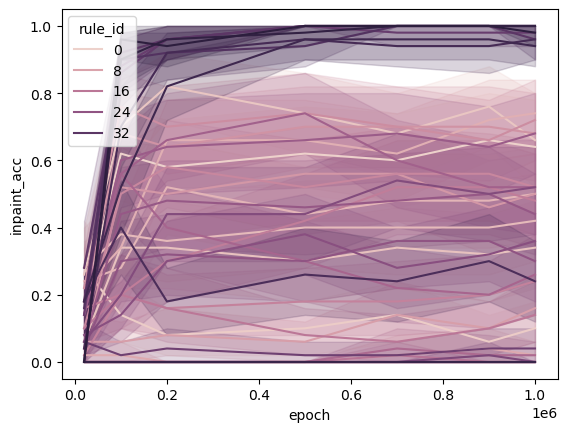

In [39]:
sns.lineplot(data=df_all, x="epoch", y="inpaint_acc", hue="rule_id")

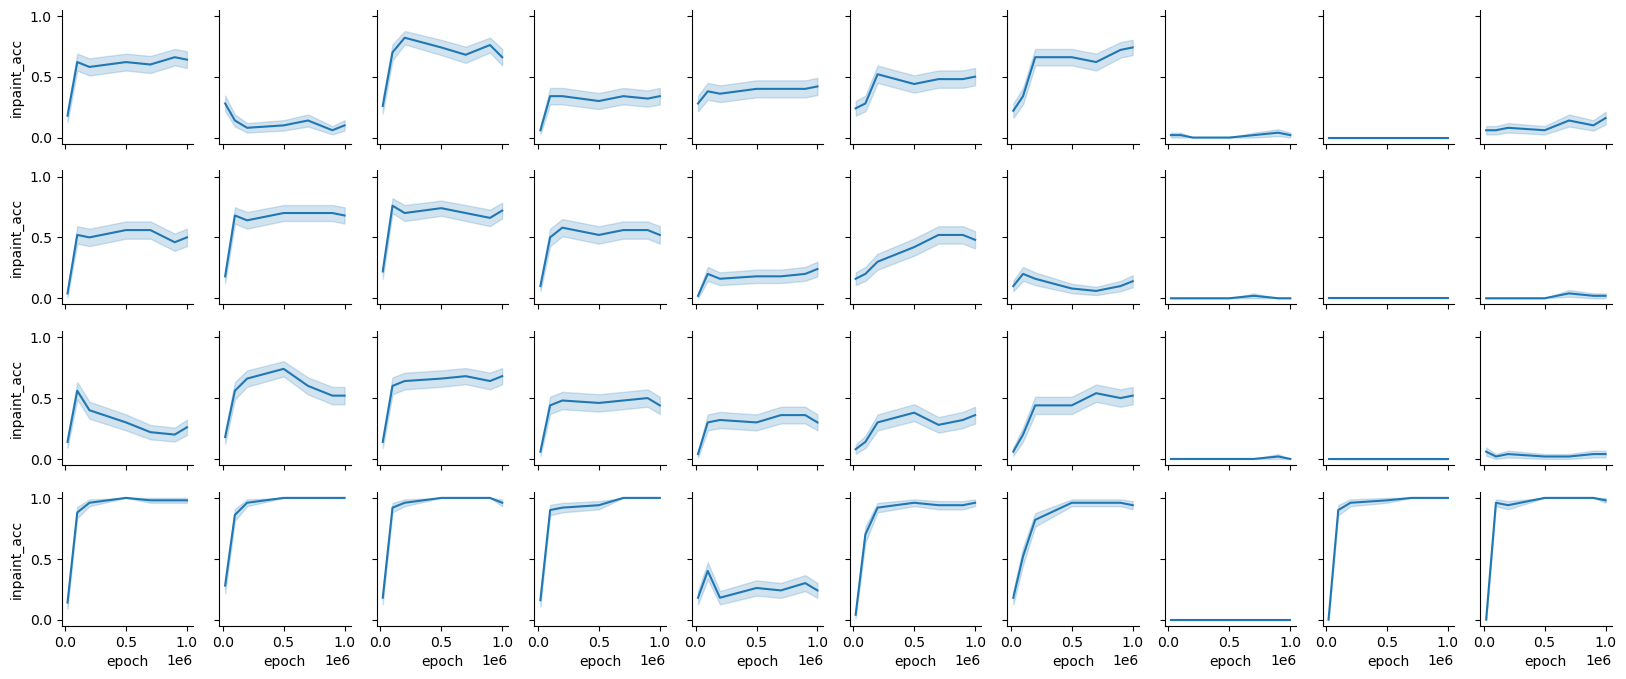

In [49]:
figh, axs = plt.subplots(4, 10, figsize=(20, 8), sharex=True, sharey=True)
axs = axs.flatten()
for i in range(40):
    ax = axs[i]
    sns.lineplot(data=df_all[df_all["rule_id"]==i], x="epoch", y="inpaint_acc", ax=ax, errorbar="se") # hue="rule_id", 
    ax.set_ylim(-0.05, 1.05)
    # sns.histplot(df_all[df_all["rule_id"]==i]["inpaint_acc"], ax=ax)
    # ax.set_title(f"rule {i}")


In [17]:
pklpaths = glob(join(outdir, "inpaint_stats_*.pkl"))
for pklpath in pklpaths:
    print(pklpath)
    # extract savestr from pklpath
    savestr = re.search(r"inpaint_stats_(.*).pkl", pklpath).group(1)
    inpaint_stats_df = pd.read_pickle(pklpath)
    

,rule_id,sample_id,inpaint_acc,valid_acc
0,0,50,0.0,1.0
1,0,51,1.0,1.0
2,0,52,0.0,0.0
3,0,53,0.0,0.0
4,0,54,0.0,1.0
...,...,...,...,...
1995,39,95,1.0,1.0
1996,39,96,1.0,1.0
1997,39,97,1.0,1.0
1998,39,98,1.0,1.0


### Sweep across 

In [90]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_inpainting"
syndir = join(figroot, "synopsis")
os.makedirs(syndir, exist_ok=True)

In [ ]:
!echo {exproot}/090-RAVEN10_abstract*

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204


In [57]:

match = glob(join(exproot, "*-RAVEN10_abstract*"))
expdir = match[0]
expname = expdir.split("/")[-1]
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
outdir = join(expdir, "inpainting_results")

In [60]:
import os

In [92]:
df_syn = []
outdir_col = sorted(glob(join(exproot, "*-RAVEN10_abstract*","inpainting_results")))
for outdir in outdir_col:
    # find the parent folder of the outdir using os
    parentdir = os.path.dirname(outdir)
    expname = os.path.basename(parentdir)
    print(expname)
    pklpaths = glob(join(outdir, "inpaint_stats_*.pkl"))
    for pklpath in pklpaths:
        print(os.path.basename(pklpath))
        # extract savestr from pklpath
        savestr = re.search(r"inpaint_stats_(.*).pkl", pklpath).group(1)
        match = re.search(r"inpaint_stats_ep(\d+)_(\d+)_(\d+)_batch(\d+)\.pkl", pklpath)
        epoch, sample_beg, sample_end, batch = match.groups()
        epoch, sample_beg, sample_end, batch = int(epoch), int(sample_beg), int(sample_end), int(batch)
        inpaint_stats_df = pd.read_pickle(pklpath)
        # inpaint_stats_df = pd.read_pickle(join(outdir, f"inpaint_stats_{savestr}.pkl"))
        inpaint_stats_df["epoch"] = epoch
        inpaint_stats_df["expname"] = expname
        df_syn.append(inpaint_stats_df)
        # results_col = pkl.load(open(join(outdir, f"inpaint_results_{savestr}.pkl"), "rb"))
df_syn = pd.concat(df_syn, axis=0)

085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204
inpaint_stats_ep1000000_50_100_batch25.pkl
086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204
inpaint_stats_ep1000000_50_100_batch25.pkl
087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204
inpaint_stats_ep1000000_50_100_batch25.pkl
088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204
inpaint_stats_ep1000000_50_100_batch25.pkl
089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204
inpaint_stats_ep1000000_50_100_batch25.pkl
090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204
inpaint_stats_ep100000_50_100_batch25.pkl
inpaint_stats_ep500000_50_100_batch25.pkl
inpaint_stats_ep1000000_50_100_batch25.pkl
inpaint_stats_ep200000_50_100_batch25.pkl
inpaint_stats_ep700000_50_100_batch25.pkl
inpaint_stats_ep20000_50_100_batch25.pkl
inpaint_stats_ep900000_50_100_batch25.pkl
091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205
inpaint_stats_ep1000000_50_100_batch25

In [93]:
df_syn.query("epoch==1000000").groupby("expname")["inpaint_acc"].mean()

expname
085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204              0.5270
086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204               0.5365
087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204                0.5425
088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204       0.4545
089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204      0.4555
090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204     0.4515
091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205                0.5295
092-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_20240711-0205               0.5370
093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205      0.4500
094-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_20240711-0205     0.4425
095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205       0.4640
096-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_20240711-0205              0.5490
097-RAVE

In [68]:
def extract_and_convert(string):
    # Pattern to match the "0_16" part and convert to float 0.16
    match1 = re.search(r'stream(\d+)_(\d+)', string)
    if match1:
        num1 = match1.group(1)
        num2 = match1.group(2)
        result = float(f"{num1}.{num2}")
        return result
    
    # Pattern to match the "16M" part and convert to integer 16
    match2 = re.search(r'stream(\d+)M', string)
    if match2:
        result = int(match2.group(1))
        return result
    
    return None

In [94]:
df_syn["heldout"] = df_syn.expname.map(lambda x: "_heldout0" in x)
df_syn["scale"] = df_syn.expname.map(lambda x: "DiT_B_1" if "DiT_B_1" in x else "DiT_S_1" if "DiT_S_1" in x else None)
df_syn["dataset_size"] = df_syn.expname.map(extract_and_convert)
heldout_ids = [1, 16, 20, 34, 37]
df_syn["heldout_rule"] = df_syn.rule_id.map(lambda x: x in heldout_ids) & df_syn.heldout


In [95]:
df_syn.groupby("expname").agg({"heldout_rule":"sum"})

,heldout_rule
expname,
085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204,0
086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204,0
087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204,0
088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204,250
089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204,250
090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204,1750
091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205,0
092-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_20240711-0205,0
093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205,250


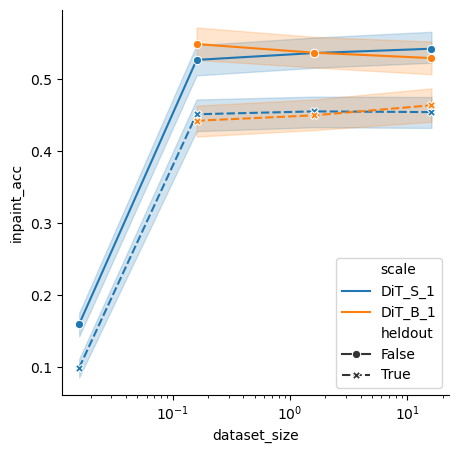

In [96]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=df_syn.query("epoch==1000000"), x="dataset_size", y="inpaint_acc", hue="scale", style="heldout", markers=True, )
plt.xscale("log")

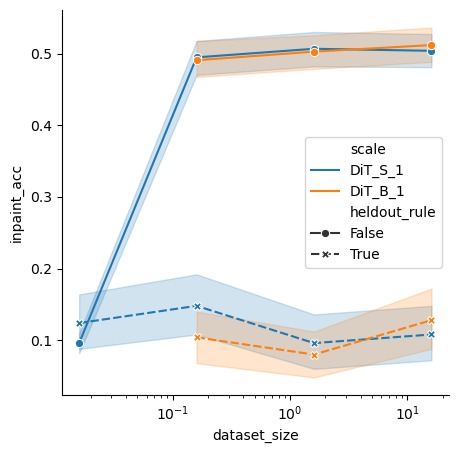

In [97]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=df_syn.query("epoch==1000000 and heldout==True"), x="dataset_size", y="inpaint_acc", hue="scale", style="heldout_rule", markers=True, )
plt.xscale("log")

In [98]:
df_syn.query("epoch==1000000").groupby("expname")["inpaint_acc"].mean()

expname
085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204              0.5270
086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204               0.5365
087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204                0.5425
088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204       0.4545
089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204      0.4555
090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204     0.4515
091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205                0.5295
092-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_20240711-0205               0.5370
093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205      0.4500
094-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_20240711-0205     0.4425
095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205       0.4640
096-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_20240711-0205              0.5490
097-RAVE

In [ ]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_inpainting"

In [ ]:
!echo {exproot}/090-RAVEN10_abstract*

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204


In [ ]:
pklpaths = glob(join(outdir, "inpaint_stats_*.pkl"))
df_all = []
for pklpath in pklpaths:
    print(pklpath)
    # extract savestr from pklpath
    savestr = re.search(r"inpaint_stats_(.*).pkl", pklpath).group(1)
    match = re.search(r"inpaint_stats_ep(\d+)_(\d+)_(\d+)_batch(\d+)\.pkl", pklpath)
    epoch, sample_beg, sample_end, batch = match.groups()
    epoch, sample_beg, sample_end, batch = int(epoch), int(sample_beg), int(sample_end), int(batch)
    inpaint_stats_df = pd.read_pickle(pklpath)
    # inpaint_stats_df = pd.read_pickle(join(outdir, f"inpaint_stats_{savestr}.pkl"))
    inpaint_stats_df["epoch"] = epoch
    df_all.append(inpaint_stats_df)
    # results_col = pkl.load(open(join(outdir, f"inpaint_results_{savestr}.pkl"), "rb"))
df_all = pd.concat(df_all, axis=0)

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/inpainting_results/inpaint_stats_ep100000_50_100_batch25.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/inpainting_results/inpaint_stats_ep500000_50_100_batch25.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/inpainting_results/inpaint_stats_ep1000000_50_100_batch25.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/inpainting_results/inpaint_stats_ep200000_50_100_batch25.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0